c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 阶段 0: 数据准备 ---
Training data shape:   (2688, 24)
Validation data shape: (2399, 24)
Testing data shape:    (2664, 24)

Identified 12 WiFi features and 9 IMU features.
数据已在DataFrame上完成标准化。
正在从DataFrame创建异构图数据列表 (消融试验版)...
数据加载器创建完毕。

--- 阶段 1: 模型实例化 (消融试验版: GNN + MLP) ---
端到端模型实例化完成 (GNN-LSTM-MLP)。

--- 开始单阶段训练 (消融试验：仅基础损失) ---


Training Epochs:  13%|█▎        | 63/500 [01:00<06:58,  1.04it/s, LR=0.000300, TrainLoss=0.0227, ValLoss=0.0127]



训练早停于 Epoch 64
--- 训练完成 ---
最佳模型已保存至: Model/ablation_best_model.pth

--- 最终测试: 加载训练后的最佳模型 ---


Testing: 100%|██████████| 21/21 [00:00<00:00, 52.54it/s]


Test Loss: 0.0059
Test results saved to 'results/GMLP_ablation_GNNMLP_Cheku.csv'

--- 模型评估结果 (GNN-MLP 消融试验) ---
X轴均方误差 (MSE X): 0.3891 (米^2)
Y轴均方误差 (MSE Y): 14.6302 (米^2)
总均方根误差 (RMSE): 2.7404 (米)
平均位移误差 (ADE/FDE): 3.2004 (米)
---------------------------------


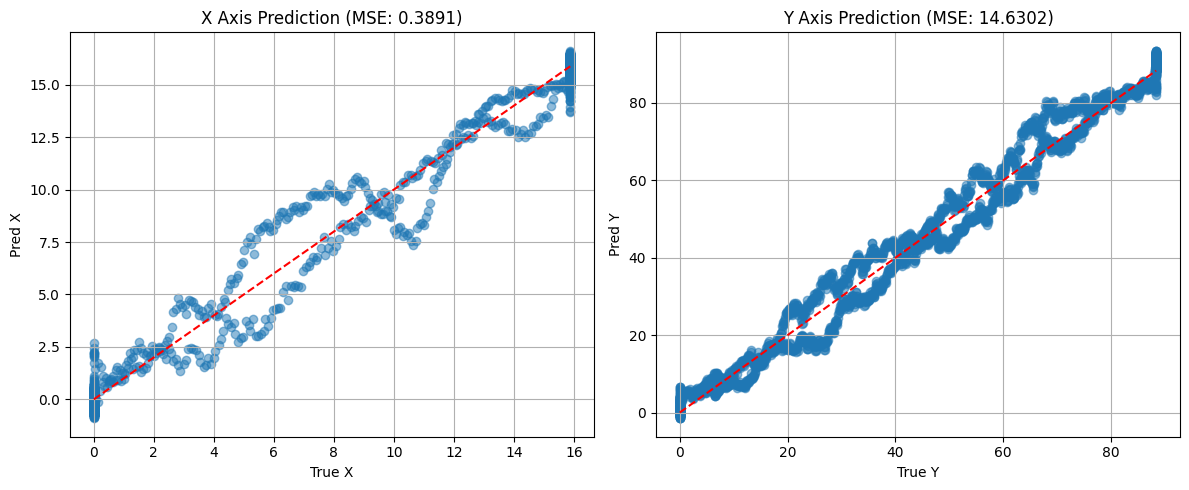

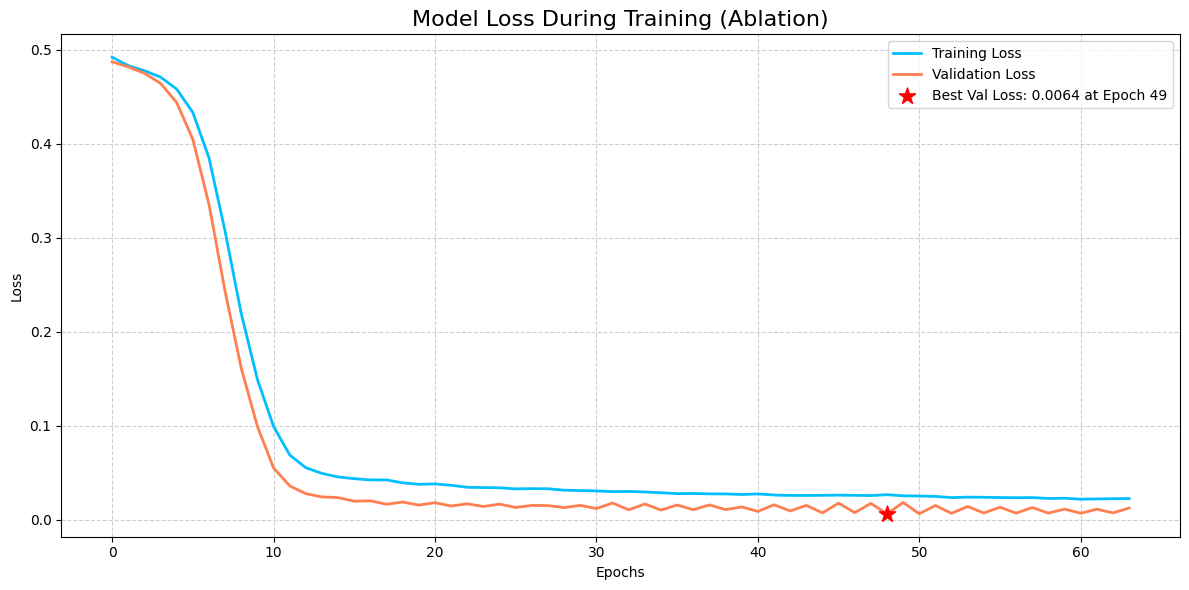

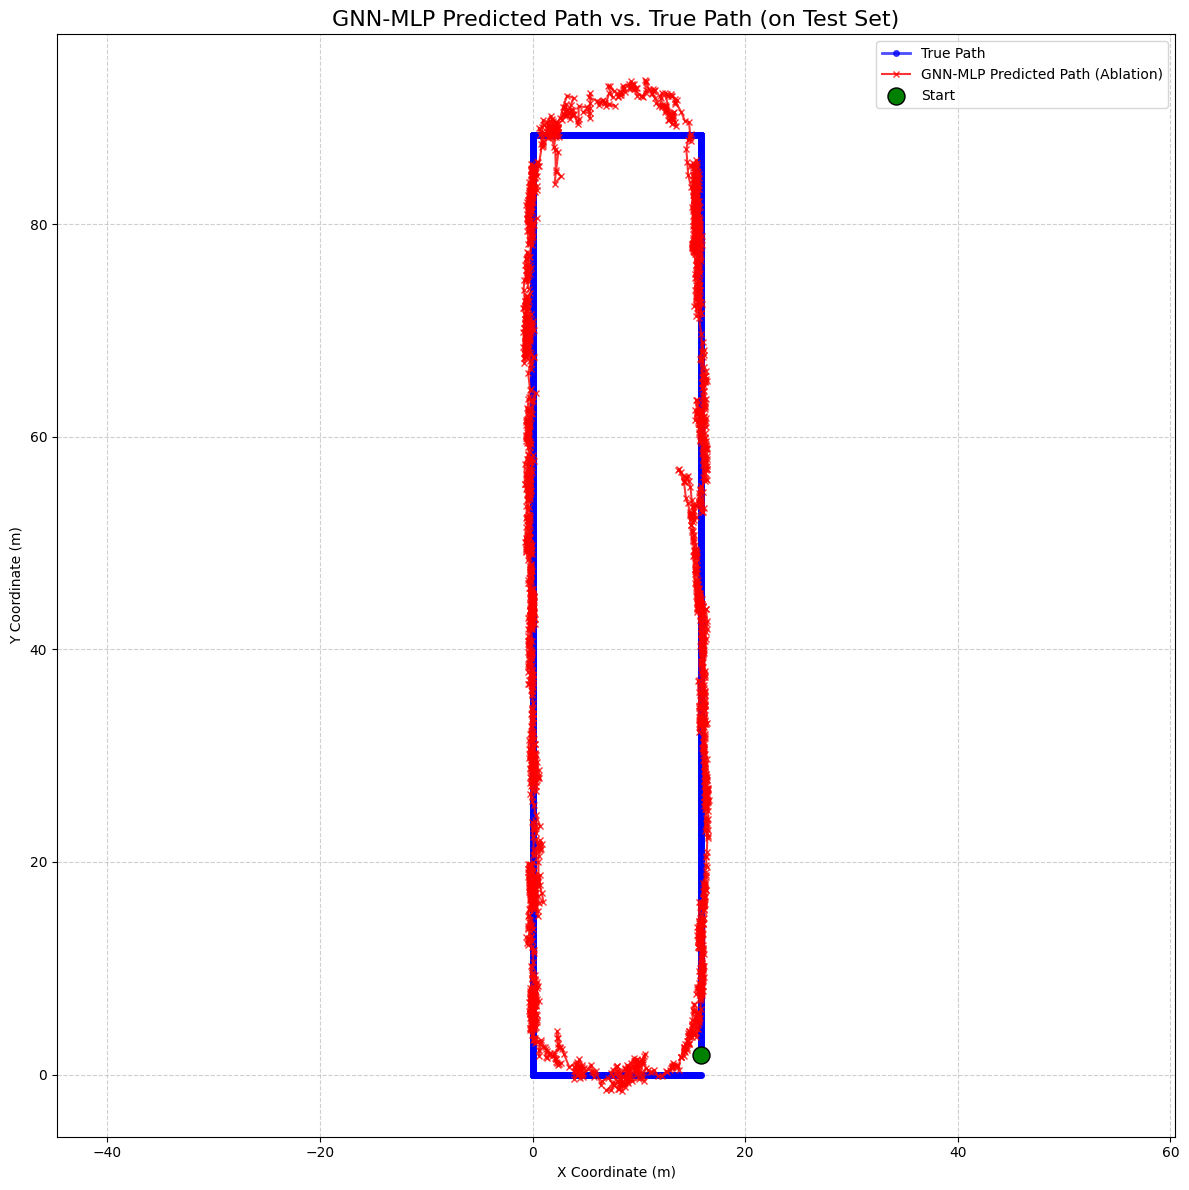

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 将上一级目录 (即 loss_function 所在的目录) 添加到 Python 的搜索路径
# ==============================================================================
#                      【请在此处导入上文定义的模块】
# ==============================================================================
# 假设您将上面的代码保存在一个文件中，例如 "ablation_modules.py"
# from ablation_modules import GNNEncoder, create_graph_list_from_df_ablation, MLPPredictor
from utils import GNNEncoder, create_graph_list_from_df_ablation, create_temporal_edges_with_attr, MLPPredictor, GNN_LSTKAN_with_Attention_v2
# (这里我们假设您已将它们粘贴到顶部)

# 【重要】您仍然需要导入您的 GNN_LSTKAN_with_Attention_V2，
# 因为它作为 GNN 和 预测器 的包装器。
# from loss_function.GNN_LSTM_with_Attention_V2 import GNN_LSTKAN_with_Attention_v2
# from kan_improved import KAN # <-- 不再需要 KAN

# ==============================================================================
#                    第一部分: 数据加载与预处理 (与您的代码相同)
# ==============================================================================
print("--- 阶段 0: 数据准备 ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# direct = "../Datasets/"
filesname = "GNNMLP_Cheku.csv"
# print(f"filename is {filesname}")
# data = pd.read_csv(direct + filesname)
# train_ratio = 0.8
# val_ratio = 0.1
# data_size = len(data)
# train_end_idx = int(train_ratio * data_size)
# val_end_idx = train_end_idx + int(val_ratio * data_size)
# train_data = data.iloc[:train_end_idx]
# val_data = data.iloc[train_end_idx:val_end_idx]
# test_data = data.iloc[val_end_idx:]

train_data = pd.read_csv(r'../Datasets/x_train.csv')
val_data = pd.read_csv(r'../Datasets/x_val.csv')
test_data = pd.read_csv(r'../Datasets/x_test.csv')
print(f"Training data shape:   {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape:    {test_data.shape}")

column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
coord_cols = ['x_coord', 'y_coord']
# wifi_features = [col for col in column_names if any(sensor in col for sensor in ["rot", "RSSI"])] 
# imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope"])] 
wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])]
imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])]
print(f"\nIdentified {len(wifi_features)} WiFi features and {len(imu_features)} IMU features.")

scaler_wifi = StandardScaler().fit(train_data[wifi_features])
scaler_imu = StandardScaler().fit(train_data[imu_features])
scaler_coords = StandardScaler().fit(train_data[coord_cols])

train_df_scaled = train_data.copy()
val_df_scaled = val_data.copy()
test_df_scaled = test_data.copy()

for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
    df[wifi_features] = scaler_wifi.transform(df[wifi_features])
    df[imu_features] = scaler_imu.transform(df[imu_features])
    df[coord_cols] = scaler_coords.transform(df[coord_cols])
print("数据已在DataFrame上完成标准化。")

# --- 【消融试验修改】 ---
windows_size = 20
future_steps = 3
# 移除了 future_radius 和 past_radius

print("正在从DataFrame创建异构图数据列表 (消融试验版)...")
# 【消融试验修改】调用新的图创建函数
train_data_list = create_graph_list_from_df_ablation(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')
val_data_list = create_graph_list_from_df_ablation(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')
test_data_list = create_graph_list_from_df_ablation(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')

batch_size = 128
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)
print("数据加载器创建完毕。")

# ==============================================================================
#                    第二部分: 模型实例化 (消融试验修改)
# ==============================================================================
print("\n--- 阶段 1: 模型实例化 (消融试验版: GNN + MLP) ---")
wifi_feat_dim = len(wifi_features)
imu_feat_dim = len(imu_features)
gnn_hidden_dim = 32
mlp_output_dim = future_steps * 2 # 保持不变 (原 kan_output_dim)
gnn_heads = 4
dropout_p = 0.2 # 保持不变 (原 kan_dropout)

gnn_encoder_instance = GNNEncoder(
    wifi_input_dim=wifi_feat_dim,
    imu_input_dim=imu_feat_dim,
    hidden_dim=gnn_hidden_dim,
    windows_size=windows_size,
    num_layers=1,
    heads=gnn_heads,
    dropout=dropout_p
).to(device)

# 【消融试验修改】使用 MLP 预测器
mlp_layers_config = [gnn_hidden_dim, 64, mlp_output_dim] # (原 kan_layers_config)
mlp_predictor_instance = MLPPredictor(
    layers_hidden=mlp_layers_config,
    use_lstm=True,
    lstm_hidden=32,
    dropout_rate=dropout_p,
).to(device)

# 【注意】我们仍然使用 GNN_LSTKAN_with_Attention_v2 作为包装器
# 它将 gnn_encoder 和 *mlp_predictor_instance* (作为 kan_predictor 参数传入) 组合起来
end_to_end_model = GNN_LSTKAN_with_Attention_v2(
    gnn_encoder=gnn_encoder_instance,
    kan_predictor=mlp_predictor_instance, # 传入 MLP 实例
    future_steps=future_steps
).to(device)
print("端到端模型实例化完成 (GNN-LSTM-MLP)。")

# ==============================================================================
#                    第三部分：单阶段训练函数 (消融试验修改)
# ==============================================================================

def train_model(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, lambda_vel, model_save_path):
    """
    【消融试验修改】
    执行单阶段训练：
    1. 仅使用基础损失 (位置+速度)。
    2. 移除所有正则化项 (KAN reg, smooth, consistency)。
    """
    print("\n" + "="*80)
    print("--- 开始单阶段训练 (消融试验：仅基础损失) ---")
    print("="*80)
    
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 用于绘图
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Training Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            
            # 【消融试验修改】
            # 仅使用基础损失
            total_loss = loss_coord + lambda_vel * loss_vel
            # 移除了 reg_loss = model.regularization_loss()
            # 移除了 total_loss = base_loss + kan_reg_weight * reg_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
                
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}', LR=f'{optimizer.param_groups[0]["lr"]:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n训练早停于 Epoch {epoch + 1}")
            break
            
    print(f"--- 训练完成 ---")
    print(f"最佳模型已保存至: {model_save_path}")
    return train_losses, val_losses

# 【消融试验修改】移除了 train_phase_2_finetune 函数

# ==============================================================================
#                      第四部分: 主执行流程 (消融试验修改)
# ==============================================================================
if __name__ == "__main__":
    
    # --- 定义超参数 (单阶段) ---
    os.makedirs('Model', exist_ok=True)
    
    LR = 3e-4         # 原 PHASE_1_LR
    EPOCHS = 500      # 原 PHASE_1_EPOCHS
    PATIENCE = 15     # 原 PHASE_1_PATIENCE
    
    WEIGHT_DECAY = 2e-4
    LAMBDA_VEL = 0.3
    
    # 移除了 KAN_REG_WEIGHT, SMOOTH_WEIGHT, CONSISTENCY_WEIGHT
    # 移除了 PHASE_2 的所有参数

    # --- 执行单阶段训练 ---
    best_model_path = 'Model/ablation_best_model.pth'
    train_losses, val_losses = train_model(
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        initial_lr=LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=EPOCHS,
        patience=PATIENCE,
        lambda_vel=LAMBDA_VEL,
        model_save_path=best_model_path
    )
    
    # 【消融试验修改】移除了第二阶段训练的调用

    # =================================================================
    #                       第五部分: 测试与评估
    # =================================================================
    print("\n--- 最终测试: 加载训练后的最佳模型 ---")
    end_to_end_model.load_state_dict(torch.load(best_model_path))
    
    end_to_end_model.eval()
    test_loss = 0
    pred_coords_list = []
    true_coords_list = []
    criterion = nn.HuberLoss()

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            batch = batch.to(device)
            pred_seq,_,_ = end_to_end_model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            # 测试损失 (与训练时的验证损失一致)
            loss_coord_test = criterion(pred_seq, true_seq)
            pred_vel_test = (pred_seq[:, 1:] - pred_seq[:, :-1])
            true_vel_test = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel_test = criterion(pred_vel_test, true_vel_test)
            loss = loss_coord_test + LAMBDA_VEL * loss_vel_test

            test_loss += loss.item()
            pred_last_step = pred_seq[:, -1, :].cpu().numpy()
            true_last_step = true_seq[:, -1, :].cpu().numpy()
            pred_coords_list.append(pred_last_step)
            true_coords_list.append(true_last_step)

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    pred_coords = np.concatenate(pred_coords_list, axis=0)
    true_coords = np.concatenate(true_coords_list, axis=0)
    
    # 反标准化
    pred_coords_orig = scaler_coords.inverse_transform(pred_coords)
    true_coords_orig = scaler_coords.inverse_transform(true_coords)
    
    # =================================================================
    #                      第六部分: 结果保存与可视化
    # =================================================================
    result_test_df = pd.DataFrame({
        'Pred_X': pred_coords_orig[:, 0],
        'Pred_Y': pred_coords_orig[:, 1],
        'True_X': true_coords_orig[:, 0],
        'True_Y': true_coords_orig[:, 1],
    })
    os.makedirs('results', exist_ok=True)
    # 【消融试验修改】更改保存文件名
    result_filename = f'results/GMLP_ablation_{filesname}'
    result_test_df.to_csv(result_filename, index=False)
    print(f"Test results saved to '{result_filename}'")

    mse_x = np.mean((true_coords_orig[:, 0] - pred_coords_orig[:, 0])** 2)
    mse_y = np.mean((true_coords_orig[:, 1] - pred_coords_orig[:, 1])** 2)
    rmse_total = np.sqrt(np.mean((true_coords_orig - pred_coords_orig)** 2))
    ade = np.mean(np.sqrt(np.sum((true_coords_orig - pred_coords_orig)**2, axis=1)))

    print("\n--- 模型评估结果 (GNN-MLP 消融试验) ---")
    print(f"X轴均方误差 (MSE X): {mse_x:.4f} (米^2)")
    print(f"Y轴均方误差 (MSE Y): {mse_y:.4f} (米^2)")
    print(f"总均方根误差 (RMSE): {rmse_total:.4f} (米)")
    print(f"平均位移误差 (ADE/FDE): {ade:.4f} (米)")
    print("---------------------------------")

    os.makedirs('Picture', exist_ok=True)
    
    # 散点图
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_coords_orig[:, 0], pred_coords_orig[:, 0], alpha=0.5)
    plt.plot([true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], [true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 'r--')
    plt.xlabel('True X'); plt.ylabel('Pred X'); plt.title(f'X Axis Prediction (MSE: {mse_x:.4f})'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(true_coords_orig[:, 1], pred_coords_orig[:, 1], alpha=0.5)
    plt.plot([true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], [true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 'r--')
    plt.xlabel('True Y'); plt.ylabel('Pred Y'); plt.title(f'Y Axis Prediction (MSE: {mse_y:.4f})'); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 损失曲线图 (单阶段)
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
    # 【消融试验修改】移除了 axvline
    best_val_epoch = np.argmin(val_losses)
    best_val_score = val_losses[best_val_epoch]
    plt.scatter(best_val_epoch, best_val_score, marker='*', color='red', s=150, zorder=5, label=f'Best Val Loss: {best_val_score:.4f} at Epoch {best_val_epoch+1}')
    plt.title('Model Loss During Training (Ablation)', fontsize=16)
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 轨迹对比图
    plt.figure(figsize=(12, 12))
    plt.plot(true_coords_orig[:, 0], true_coords_orig[:, 1], 'o-', label='True Path', color='blue', linewidth=2, markersize=4, alpha=0.7)
    # 【消融试验修改】更改图例
    plt.plot(pred_coords_orig[:, 0], pred_coords_orig[:, 1], 'x-', label='GNN-MLP Predicted Path (Ablation)', color='red', linewidth=1.5, markersize=4, alpha=0.8)
    if len(true_coords_orig) > 0:
        plt.scatter(true_coords_orig[0, 0], true_coords_orig[0, 1], s=150, c='green', marker='o', edgecolors='black', label='Start', zorder=5)
    plt.title('GNN-MLP Predicted Path vs. True Path (on Test Set)', fontsize=16)
    plt.xlabel('X Coordinate (m)'); plt.ylabel('Y Coordinate (m)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()